# Model identification
## Overview
Here we will learn how to fit a simplified neuron model to experimental data or to a biophysical model
## Plan
* Generalized Integrate and Fire models
* What features we want to reproduce
* Model fitting procedure: least squares

## References
1. Neuronal Dynamics book. Chapter 5. URL: https://neuronaldynamics.epfl.ch/online/Pt2.html
2. Naud, R., Marcille, N., Clopath, C., & Gerstner, W. (2008). Firing patterns in the adaptive exponential integrate-and-fire model. Biological cybernetics, 99(4), 335-347


## Homework
1. The fitting procedure doesn't provide the $u_{th}$ and $u_{reset}$. How we can estimate them?
2. Here we used the phaseplane to fit the model. Imagine we cannot measure the membrane potential, but only observe spikes. Fit the simple LIF model to the data using two features: the time to the first spike and average spike frequency.

### Generalized Integrate and Fire (GLIF)
Basic I&F model is extended in two ways:

1. Nonlinear function in the right part of the membrane potential equation
2. Second "adaptation" variable which reflects the memory of the membrane

#### Leaky Integrate and Fire:
$$\tau\frac{du}{dt} = -(u(t)-u_{rest})+RI(t)\\
\text{Spike: } t^f: u(t)\ge\theta \\
u:=u_{reset}
$$
where $u_{rest}$ - resting potential, $\theta$ - spike initiating threshold, $u_{reset}$ - afterspike reset potential

#### Nonlinear Integrate and Fire:
$$
\tau\frac{du}{dt} = f(u)+R(u)I(t) \\
\text{Spike: } t^f: u(t)\ge\theta \\
u:=u_{reset}
$$


The common used are quadratic and exponential I&F.

In [1]:
import matplotlib.pyplot as plt
import brian2 as b2

def plot_I(mon, current):
    plt.xlabel('Time (ms)')
    plt.ylabel('I (nA)')
    plt.plot(mon.t / b2.ms, current(mon.t)/b2.namp, "r", lw=2,
            label='Input current') 
    
def plot_v_spikes(v_mon, s_mon, t_bounds=None, labels=None):
    #plt.figure(figsize=(12,4))
    #plt.subplot(121)
    for i in range(len(v_mon.v)):
        if labels:
            plt.plot(v_mon.t/b2.ms, v_mon.v[i]/b2.mV, label=labels[i])
        else:
            plt.plot(v_mon.t/b2.ms, v_mon.v[i]/b2.mV, label=f'N{i}')
    for t in s_mon.t:
        plt.axvline(t/b2.ms, ls='--', c='k', lw=1)
    if t_bounds:
        plt.xlim(t_bounds)
    plt.xlabel('Time (ms)')
    plt.ylabel('Membrane voltage (mV)')
    plt.legend(loc='lower left');


### Exponential Integrate and Fire
$$
\tau\frac{du}{dt} = -(u-u_{rest})+ \Delta_T\exp(\frac{u-\theta_{rh}}{\Delta_T}) +RI(t) \\
\text{Spike: } t^f: u(t)\ge\theta \\
u:=u_{reset}
$$

In the Exp I&F there are two additional parameters. $\theta_{rh}$ is the rheobase potential, after this point the membrane potential $u(t)$ inevitably rises to the threshold and initiates a spike. $\Delta_T$ - the "sharpness" of the exponent.

Below we explore the behavior of exponential I&F

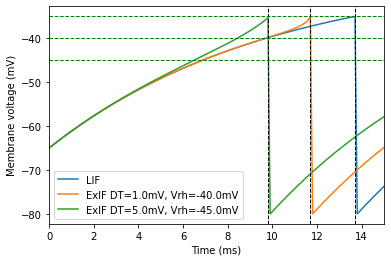

In [30]:
b2.start_scope()
tau = 10*b2.ms #milliseconds
v_rest = -65 * b2.mvolt #millivolts
v0 = -65 * b2.mvolt
v_th = -35 * b2.mvolt
v_reset = -80 * b2.mvolt
R = 10 * b2.Mohm
I = 4 * b2.namp
T = 200 * b2.ms
eqs_ex = '''
dv/dt=(v_rest-v)/tau + w_ex*DT*exp((v-v_rh)/DT)/tau + R*I/tau : volt
w_ex : 1
DT : volt
v_rh : volt
'''
G = b2.NeuronGroup(3,eqs_ex,
                   threshold='v>v_th', 
                   reset='v = v_reset', 
                   method='euler')
G.w_ex = [0,1,1]
G.v_rh = [0*b2.mvolt, -40*b2.mvolt, -45*b2.mvolt]
G.DT = [1*b2.mvolt, 1*b2.mvolt, 5*b2.mvolt]
G.v = v0
v_mon = b2.StateMonitor(G, 'v', record=True)
spikemon = b2.SpikeMonitor(G)
b2.run(T)
labels=['LIF', 
        f'ExIF DT={G.DT[1]/b2.mV}mV, Vrh={G.v_rh[1]/b2.mV}mV', 
        f'ExIF DT={G.DT[2]/b2.mV}mV, Vrh={G.v_rh[2]/b2.mV}mV']
plot_v_spikes(v_mon,spikemon, \
              labels=labels, \
              t_bounds=(0,15))
plt.axhline(G.v_rh[1]/b2.mV, ls='--', c='g', lw=1)
plt.axhline(G.v_rh[2]/b2.mV, ls='--', c='g', lw=1)
plt.axhline(v_th/b2.mV, ls='--', c='g', lw=1, label='threshold')

### Phase plane analysis 
1. Inject constant current I
2. Plot the $u(t)$ and $du/dt$

Here we also add noise to the model. The variable `xi` is like gaussian noise with standart deviation equals 1 and meand equals 0.

In [106]:
import numpy as np

def was_spike(v_mon, s_mon):
    """
    Returns logical array was_spike_ind where was_spike_ind[t] is True if 
    a spike occured at time moment t-1
    """
    spikes_ind = np.in1d(v_mon.t,spikemon.t)
    was_spike_ind = np.roll(spikes_ind,1)
    was_spike_ind[0] = False
    return was_spike_ind

def phase_var(v_mon, s_mon):
    dv_dt = np.diff(v_mon.v[0])/np.diff(v_mon.t)
    v = v_mon.v[0,1:]
    return v, dv_dt

def phase_var_grad(v_mon):
    dv_dt = np.gradient(v_mon.v[0]/b2.mV, v_mon.t/b2.ms)*b2.mV/b2.ms
    #v = v_mon.v[0,1:]
    return v_mon.v[0], dv_dt

def plot_phaseplane(v_mon, outlier_thres=200*b2.mV/b2.ms):
    #v, dv_dt = phase_var(v_mon, s_mon)
    v, dv_dt = phase_var_grad(v_mon)
    non_outlier=np.abs(dv_dt)<outlier_thres
    #v = v[np.abs(v-np.median(v))/np.median(v)<10]
    #print(np.median(v))
    plt.plot(v[non_outlier]/b2.mV, dv_dt[non_outlier]/b2.mV*b2.ms, '.')
    plt.xlabel('v (mV)')
    plt.ylabel('dv/dt (mV/ms)')
 

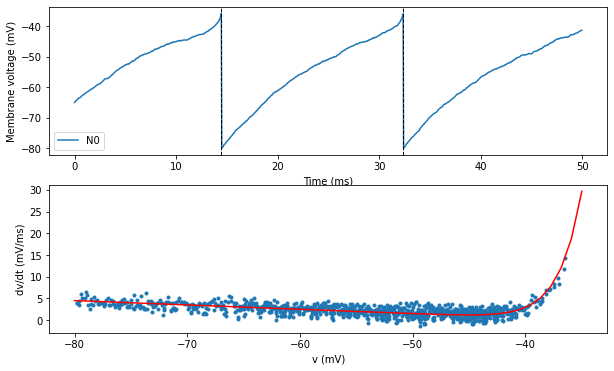

In [47]:
def ExIF(v, I, v_rest, R, tau, v_rh, DT):
    return (v_rest-v)/tau + DT*np.exp((v-v_rh)/DT)/tau + R*I/tau

b2.start_scope()
tau = 10*b2.ms #milliseconds
v_rest = -65 * b2.mV #millivolts
v0 = -65 * b2.mV
v_th = -35 * b2.mV
v_reset = -80 * b2.mV
R = 10 * b2.Mohm
I = 3 * b2.namp
T = 50 * b2.ms
v_rh = -45*b2.mvolt
DT = 2*b2.mvolt
sigma = 1*b2.mV
eqs_ex = '''
dv/dt=(v_rest-v)/tau + DT*exp((v-v_rh)/DT)/tau + R*I/tau + sigma*xi/tau**0.5 : volt
'''
G = b2.NeuronGroup(1,eqs_ex,
                   threshold='v>v_th', 
                   reset='v = v_reset', 
                   method='euler')
G.v = v0
v_mon = b2.StateMonitor(G, 'v', record=True)
spikemon = b2.SpikeMonitor(G)
b2.defaultclock.dt = 0.05*b2.ms
b2.run(T)
plt.figure(figsize=(10,6))
plt.subplot(211)
plot_v_spikes(v_mon,spikemon, \
              labels=None)

plt.subplot(212)
plot_phaseplane(v_mon)
# Plot the model curve
v_measured, dv_dt_measured = phase_var_grad(v_mon)
v_range = np.linspace(v_reset,v_th)
I_arr = np.ones(v_range.shape)*I
dv_dt_model = ExIF(v_range, I_arr, v_rest, R, tau, v_rh, DT)
plt.plot(v_range/b2.mV, dv_dt_model/b2.mV*b2.ms, 'r')

### Model fitting
Here we fit our model to the curve observed in the phase plane. 

WARNING    /tmp/ipykernel_199026/4108887373.py:9: RuntimeWarning: overflow encountered in square
  return np.sum(np.square(dvdt_model[non_outliers]/b2.mV*b2.ms - dv_dt[non_outliers]/b2.mV*b2.ms))
 [py.warnings]
WARNING    /tmp/ipykernel_199026/1097726934.py:2: RuntimeWarning: overflow encountered in exp
  return (v_rest-v)/tau + DT*np.exp((v-v_rh)/DT)/tau + R*I/tau
 [py.warnings]
WARNING    /home/sirius/ivanov_raai_2021/neuro-raai/neuro-venv/lib/python3.8/site-packages/scipy/optimize/_numdiff.py:557: RuntimeWarning: invalid value encountered in subtract
  df = fun(x) - f0
 [py.warnings]


CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH
 
v_rest=-55.94 mV,
     R= 7.604 Mohm,
   tau=  10.4 ms,
  v_rh=-44.58 mV,
   DT= 1.961 mV,
Error=1038.5828788531778



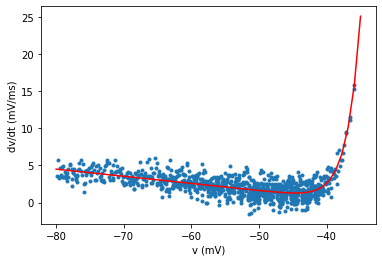

In [51]:
def err(x, v_mon, I, outlier_thres=200*b2.mV/b2.ms):
    '''
    x is an array x=[v_rest, R, tau, v_rh, DT] where each component is dimensionless
    I is the input current, should be the same size as v_mon.v[0]
    '''
    v, dv_dt = phase_var_grad(v_mon)    
    dvdt_model = ExIF(v, I, x[0]*b2.mV, x[1]*b2.Mohm, x[2]*b2.ms, x[3]*b2.mV, x[4]*b2.mV)
    non_outliers = abs(dv_dt)<outlier_thres
    return np.sum(np.square(dvdt_model[non_outliers]/b2.mV*b2.ms - dv_dt[non_outliers]/b2.mV*b2.ms))
    #return np.std(dvdt_model[non_outliers] - dv_dt[non_outliers])

# Generate data
b2.start_scope()
tau = 10*b2.ms #milliseconds
v_rest = -65 * b2.mV #millivolts
v0 = -65 * b2.mV
v_th = -35 * b2.mV
v_reset = -80 * b2.mV
R = 10 * b2.Mohm
I = 3 * b2.namp
T = 50 * b2.ms
v_rh = -45*b2.mvolt
DT = 2*b2.mvolt
sigma = 1*b2.mV
eqs_ex = '''
dv/dt=(v_rest-v)/tau + DT*exp((v-v_rh)/DT)/tau + R*I/tau + sigma*xi/tau**0.5 : volt
'''
G = b2.NeuronGroup(1,eqs_ex,
                   threshold='v>v_th', 
                   reset='v = v_reset', 
                   method='euler')
G.v = v0
v_mon = b2.StateMonitor(G, 'v', record=True)
spikemon = b2.SpikeMonitor(G)
b2.defaultclock.dt = 0.05*b2.ms
b2.run(T)

# Fit the curve
from scipy import optimize as opt
bounds = [(-120,-20), #v_rest
         (0.5, 30), #R
         (0.5, 100), #tau
         (-60, -10), #v_rh
         (0.01, 30)] #DT
bounds_for_ls = ([-120, 0, 0.01, -120, -120],
                [0, 100, 200, 0, 0])
x0 = [-100, 20, 50, -50, 15]
res_ev = opt.differential_evolution(err, bounds, (v_mon, I), popsize=100, maxiter=5000,polish=True)

res = opt.minimize(err, 
                   res_ev.x,
                   bounds=bounds,
                   args=(v_mon, I),
                  tol=0.0001)
print(res.message)
print(f""" 
v_rest={res.x[0]:6.4} mV,
     R={res.x[1]:6.4} Mohm,
   tau={res.x[2]:6.4} ms,
  v_rh={res.x[3]:6.4} mV,
   DT={res.x[4]:6.4} mV,
Error={res.fun}
""")
v_range = np.linspace(v_reset,v_th)
I_arr = np.ones(v_range.shape)*I
dv_dt_model = ExIF(v_range, I, 
                  res.x[0]*b2.mV, 
                  res.x[1]*b2.Mohm, 
                  res.x[2]*b2.ms, 
                  res.x[3]*b2.mV, 
                  res.x[4]*b2.mV)
plot_phaseplane(v_mon)
plt.plot(v_range/b2.mV, dv_dt_model/b2.mV*b2.ms, 'r')
#print(res.cost)

# Biophysical models
Here we have implemented the conductance-based model from Chapter 2 of Neuronal Dynamics.
https://neuronaldynamics.epfl.ch/online/Ch2.S2.html

There is no homework on this topic.

In [53]:
import matplotlib.pyplot as plt

def plot_v(v_mon, v_threshold = None, t_bounds=None):
    #plt.subplot(211)
    plt.plot(v_mon.t/ms, v_mon.v[0]/mvolt, label='Membrane voltage')
    plt.xlabel('Time (ms)')
    plt.ylabel('v (mV)')
    if t_bounds:
        plt.xlim(t_bounds)
    if v_threshold:
        plt.axhline(v_threshold/mvolt, ls='--', c='C2', label='threshold') #plot threshold


def plot_I(mon, current, t_bounds=None):
    plt.xlabel('Time (ms)')
    plt.ylabel('I (nA)')
    if t_bounds:
        plt.xlim(t_bounds)
    plt.plot(mon.t / ms, current(mon.t)/namp, "r", lw=2,
            label='Input current') 
    
def plot_gating(mon, t_bounds=None):
    plt.plot(mon.t / ms, mon.m[0],
            label='Na activation (m)')
    plt.plot(mon.t / ms, mon.n[0],
            label='Na inactivation (n)')
    plt.plot(mon.t / ms, mon.h[0],
            label='K activation (h)')
    if t_bounds:
        plt.xlim(t_bounds)
    plt.xlabel('Time (ms)')
    plt.ylabel('Gating variables')
    plt.legend();

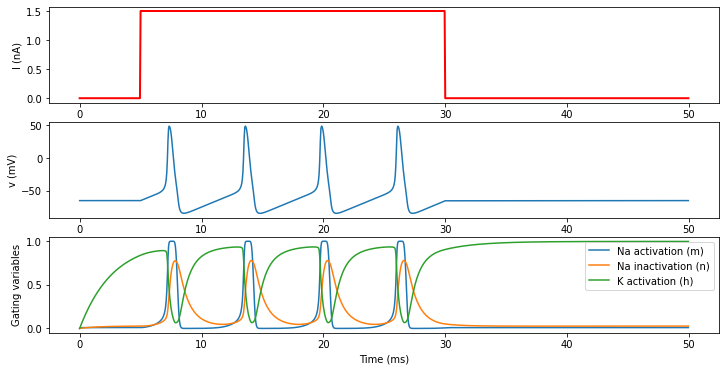

In [63]:
from brian2 import *
start_scope()
num_neurons = 1
duration = 50*ms

# Parameters
area = 20000*umetre**2
Cm = 1*ufarad*cm**-2 * area
gl = 5e-5*siemens*cm**-2 * area
El = -65*mV
EK = -90*mV
ENa = 50*mV
g_na = 100*msiemens*cm**-2 * area
g_kd = 30*msiemens*cm**-2 * area
VT = -63*mV
I_subthres = 0.5
I_low = 1.5
I_high = 2.5
I_arr = [0]*1 + [I_low]*5 + [0]*1
I = TimedArray(I_arr * nA, dt=5 * ms)
# The model
eqs = Equations('''
dv/dt = (gl*(El-v) - g_na*(m*m*m)*h*(v-ENa) - g_kd*(n*n*n*n)*(v-EK) + I(t))/Cm : volt
dm/dt = 0.32*(mV**-1)*4*mV/exprel((13.*mV-v+VT)/(4*mV))/ms*(1-m)-0.28*(mV**-1)*5*mV/exprel((v-VT-40.*mV)/(5*mV))/ms*m : 1
dn/dt = 0.032*(mV**-1)*5*mV/exprel((15.*mV-v+VT)/(5*mV))/ms*(1.-n)-.5*exp((10.*mV-v+VT)/(40.*mV))/ms*n : 1
dh/dt = 0.128*exp((17.*mV-v+VT)/(18.*mV))/ms*(1.-h)-4./(1+exp((40.*mV-v+VT)/(5.*mV)))/ms*h : 1
''')
# Threshold and refractoriness are only used for spike counting
group = NeuronGroup(num_neurons, eqs,
                    threshold='v > -40*mV',
                    refractory='v > -40*mV',
                    method='exponential_euler')
group.v = El


#group.I = '0.7*nA'
#group.I = I

s_monitor = SpikeMonitor(group)
v_monitor = StateMonitor(group, ["v","m","n","h"], record=True)

run(duration)

fig = figure(figsize=(12,6))
subplot(3,1,1)
plot_I(v_monitor, I)
subplot(3,1,2)
plot_v(v_monitor)
subplot(3,1,3)
plot_gating(v_monitor)

v_monitor_bio = v_monitor

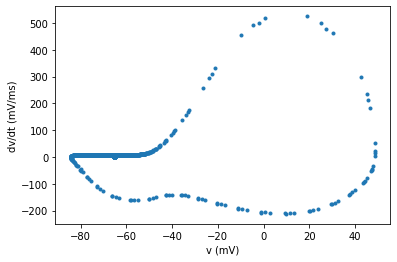

In [64]:
plot_phaseplane(v_monitor, outlier_thres=2000*b2.mV/b2.ms)

In [138]:
def plot_phaseplane_new(v_mon):
    #v, dv_dt = phase_var(v_mon, s_mon)
    v, dv_dt = phase_var_grad(v_mon)
    non_outlier = (dv_dt > 0) & (v < 0)
    #v = v[np.abs(v-np.median(v))/np.median(v)<10]
    #print(np.median(v))
    plt.plot(v[non_outlier]/b2.mV, dv_dt[non_outlier]/b2.mV*b2.ms, '.')
    plt.xlabel('v (mV)')
    plt.ylabel('dv/dt (mV/ms)')

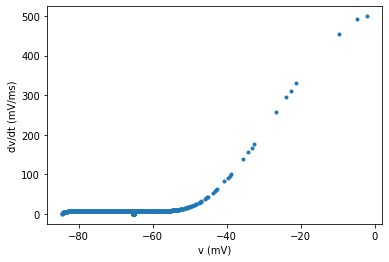

In [139]:
plot_phaseplane_new(v_monitor_bio)

WARNING    /tmp/ipykernel_199026/3716932648.py:2: RuntimeWarning: overflow encountered in exp
  return (v_rest-v)/tau + DT*np.exp((v-v_rh)/DT)/tau + R*I/tau
 [py.warnings]
WARNING    /tmp/ipykernel_199026/3251466169.py:11: RuntimeWarning: overflow encountered in square
  return np.sum(np.square(dvdt_model[non_outliers]/b2.mV*b2.ms - dv_dt[non_outliers]/b2.mV*b2.ms))
 [py.warnings]


CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH
 
v_rest=-116.0 mV,
     R= 16.81 Mohm,
   tau= 1.424 ms,
  v_rh= -60.0 mV,
   DT= 7.192 mV,
Error=19914.67925923132



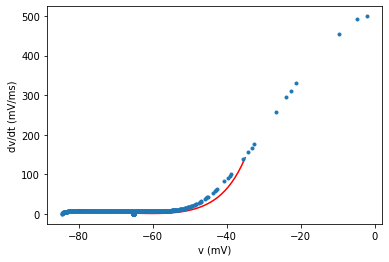

In [145]:
v_mon = v_monitor_bio

def err(x, v_mon, I):
    '''
    x is an array x=[v_rest, R, tau, v_rh, DT] where each component is dimensionless
    I is the input current, should be the same size as v_mon.v[0]
    '''
    v, dv_dt = phase_var_grad(v_mon)    
    dvdt_model = ExIF(v, I, x[0]*b2.mV, x[1]*b2.Mohm, x[2]*b2.ms, x[3]*b2.mV, x[4]*b2.mV)
    non_outliers = (dv_dt > 0) & (v < -30*b2.mV)
    return np.sum(np.square(dvdt_model[non_outliers]/b2.mV*b2.ms - dv_dt[non_outliers]/b2.mV*b2.ms))
    #return np.std(dvdt_model[non_outliers] - dv_dt[non_outliers])

# Generate data
b2.start_scope()
tau = 10*b2.ms #milliseconds
v_rest = -65 * b2.mV #millivolts
v0 = -65 * b2.mV
v_th = -35 * b2.mV
v_reset = -80 * b2.mV
R = 10 * b2.Mohm
I = 3 * b2.namp
T = 50 * b2.ms
v_rh = -45*b2.mvolt
DT = 2*b2.mvolt
sigma = 1*b2.mV
eqs_ex = '''
dv/dt=(v_rest-v)/tau + DT*exp((v-v_rh)/DT)/tau + R*I/tau + sigma*xi/tau**0.5 : volt
'''
G = b2.NeuronGroup(1,eqs_ex,
                   threshold='v>v_th', 
                   reset='v = v_reset', 
                   method='euler')
G.v = v0
# v_mon = b2.StateMonitor(G, 'v', record=True)
# spikemon = b2.SpikeMonitor(G)
b2.defaultclock.dt = 0.05*b2.ms
b2.run(T)

# Fit the curve
from scipy import optimize as opt
bounds = [(-120,-20), #v_rest
         (0.5, 30), #R
         (0.5, 100), #tau
         (-60, -10), #v_rh
         (0.01, 30)] #DT
bounds_for_ls = ([-120, 0, 0.01, -120, -120],
                [0, 100, 200, 0, 0])
x0 = [-100, 20, 50, -50, 15]
res_ev = opt.differential_evolution(err, bounds, (v_mon, I), popsize=100, maxiter=5000,polish=True)

res = opt.minimize(err, 
                   res_ev.x,
                   bounds=bounds,
                   args=(v_mon, I),
                  tol=0.0001)
print(res.message)
print(f""" 
v_rest={res.x[0]:6.4} mV,
     R={res.x[1]:6.4} Mohm,
   tau={res.x[2]:6.4} ms,
  v_rh={res.x[3]:6.4} mV,
   DT={res.x[4]:6.4} mV,
Error={res.fun}
""")
v_range = np.linspace(v_reset,v_th)
I_arr = np.ones(v_range.shape)*I
dv_dt_model = ExIF(v_range, I, 
                  res.x[0]*b2.mV, 
                  res.x[1]*b2.Mohm, 
                  res.x[2]*b2.ms, 
                  res.x[3]*b2.mV, 
                  res.x[4]*b2.mV)

# plot_phaseplane_new(v_mon)
plt.plot(v_range/b2.mV, dv_dt_model/b2.mV*b2.ms, 'r')
#print(res.cost)
plot_phaseplane_new(v_monitor_bio)